#### Imports

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull
from matplotlib.path import Path
import geopy.distance
from scipy.optimize import curve_fit

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import Pipeline

from get_data import get_ride_data

import pickle
import os

# Load ride and accident data

In [2]:
# Dateien laden; wenn pickled DataFrame existiert, lade es; wenn nicht, von der Webseite herunterladen
try:
    df_rides = pd.read_pickle('data_frames/df_rides.pkl')
except FileNotFoundError:
    df_rides=get_ride_data()
    df_rides.to_pickle('data_frames/df_rides.pkl')

In [3]:
df_all_accidents = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes_20250617.zip')
df_all_accidents = pd.DataFrame(df_all_accidents[['CRASH DATE', 'CRASH TIME', 'LATITUDE', 'LONGITUDE',\
                                     'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED']])

/var/folders/js/p6l1kx1j7wq3vt1m5pg_p9q80000gq/T/ipykernel_33036/2605770353.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all_accidents = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes_20250617.zip')


# Clean ride data

## missing values

In [4]:
df_rides.isna().sum()

rideable_type     0
started_at        0
ended_at          0
start_lat         0
start_lng         0
end_lat          16
end_lng          16
member_casual     0
dtype: int64

In [5]:
df_rides[df_rides.isnull().any(axis=1)]

,rideable_type,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,member_casual
483,classic_bike,2020-08-29 16:10:28.047,2020-08-29 16:36:24.005,40.720196,-73.989978,NaN,NaN,member
606,electric_bike,2020-11-29 09:59:50.300,2020-11-29 10:38:54.033,40.714851,-74.011223,NaN,NaN,casual
1571,classic_bike,2020-05-24 15:39:05.899,2020-05-24 18:12:42.764,40.785785,-73.957481,NaN,NaN,casual
1591,classic_bike,2020-04-04 08:33:16.082,2020-04-04 08:50:33.933,40.763605,-73.989180,NaN,NaN,member
2111,classic_bike,2021-03-11 11:29:21.042,2021-03-11 11:38:59.942,40.755941,-74.002116,NaN,NaN,member
2720,electric_bike,2021-05-27 15:20:20.634,2021-05-27 16:21:10.381,40.736245,-73.984737,NaN,NaN,casual
2831,classic_bike,2021-06-19 15:52:22.873,2021-06-19 16:10:15.771,40.691782,-73.973729,NaN,NaN,casual
3437,electric_bike,2021-12-15 09:57:36.838,2021-12-16 10:57:32.101,40.770513,-73.988038,NaN,NaN,member
4554,classic_bike,2021-02-12 12:01:02.154,2021-02-12 15:38:05.420,40.761080,-73.930562,NaN,NaN,member
4611,classic_bike,2021-08-29 12:34:13.884,2021-08-29 12:41:19.327,40.773763,-73.962221,NaN,NaN,member


In [6]:
df_has_na = df_rides[df_rides.isnull().any(axis=1)]
print(f'\nReduziert um {df_has_na.shape[0]} von {df_rides.shape[0]} to {df_rides.shape[0]-df_has_na.shape[0]}')


Reduziert um 16 von 16596 to 16580


In [7]:
df_rides = df_rides.dropna()

## make distance column

In [8]:
df_rides['distance'] = \
df_rides.apply(lambda x: geopy.distance.geodesic((x['start_lat'], x['start_lng']), (x['end_lat'], x['end_lng'])).km, axis=1)

## duration

### initial

In [9]:
# set date columns to datetime type and get duration
df_rides['started_at'] = pd.to_datetime(df_rides['started_at'], format = 'mixed')
df_rides['ended_at'] = pd.to_datetime(df_rides['ended_at'], format = 'mixed')
df_rides['duration_minutes'] = (df_rides['ended_at'] - df_rides['started_at']).dt.seconds/60

df_rides['duration_minutes'].describe()

count    16580.000000
mean        14.717786
std         29.675641
min          0.016667
25%          5.600000
50%          9.933333
75%         17.420833
max       1394.716667
Name: duration_minutes, dtype: float64

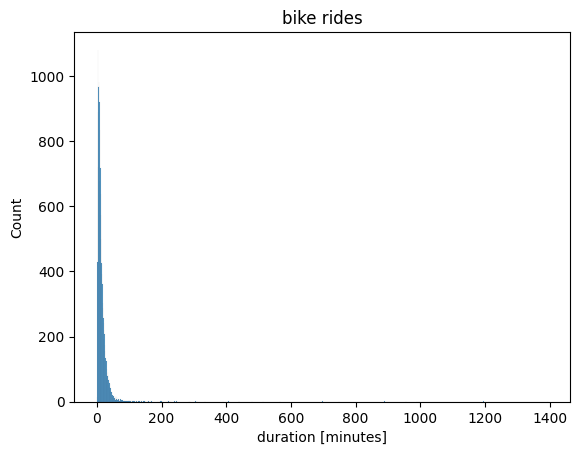

In [10]:
sns.histplot(data=df_rides['duration_minutes']).set(title = 'bike rides', xlabel = 'duration [minutes]')
plt.savefig('plots/rides_duration_no_cut.pdf')

### cut

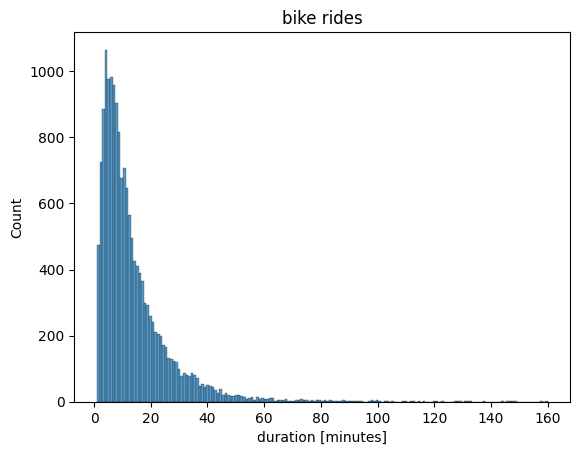

In [11]:
upper_cut_off_duration = df_rides['duration_minutes'].mean() + 5*df_rides['duration_minutes'].std()
lower_cut_off_duration = 1

series_duration_cut = (lower_cut_off_duration<df_rides['duration_minutes']) & (df_rides['duration_minutes']<upper_cut_off_duration)

sns.histplot(data=df_rides[series_duration_cut]['duration_minutes']).set(title = 'bike rides', xlabel = 'duration [minutes]')
plt.savefig('plots/rides_duration.pdf')

In [12]:
#time_cut = (df_rides['duration'] > '60 seconds') & (df_rides['duration'] < '1 days')
df_long_short=df_rides[~series_duration_cut]
df_rides = df_rides[series_duration_cut]
print(f'\nReduziert um {df_long_short.shape[0]} von {df_rides.shape[0]+df_long_short.shape[0]} auf {df_rides.shape[0]}')


Reduziert um 58 von 16580 auf 16522


## distance

### initial

In [13]:
df_rides['distance'].describe()

count    16522.000000
mean         1.954944
std          1.728012
min          0.000000
25%          0.825818
50%          1.460543
75%          2.567868
max         17.879201
Name: distance, dtype: float64

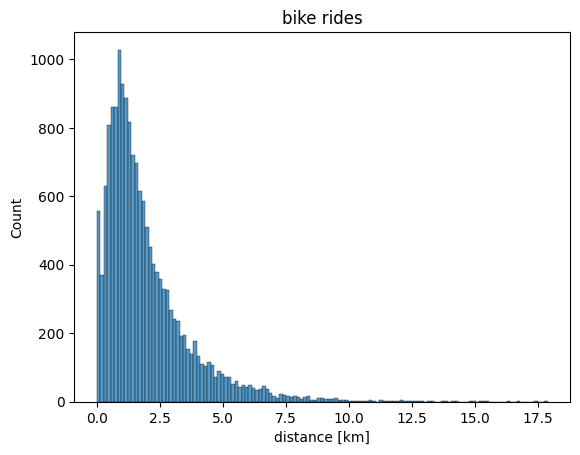

In [14]:
sns.histplot(data = df_rides['distance']).set(xlabel = 'distance [km]', title = 'bike rides')
plt.savefig('plots/rides_distance_no_cut.pdf')

### cut

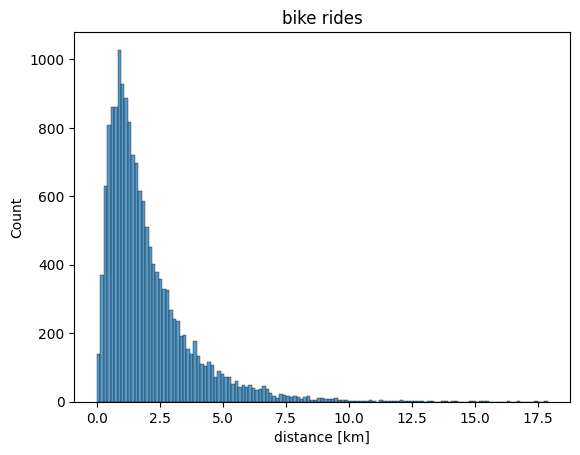

In [15]:
lower_cut_distance = 0

series_distance_cut = lower_cut_distance<df_rides['distance']

sns.histplot(data=df_rides[series_distance_cut]['distance']).set(title = 'bike rides', xlabel = 'distance [km]')
plt.savefig('plots/rides_distance.pdf')

In [16]:
series_no_dist = df_rides['distance'] == 0
df_rides = df_rides[~series_no_dist]
print(f'\nReduziert um {series_no_dist.sum()} von {df_rides.shape[0]+series_no_dist.sum()} to {df_rides.shape[0]}')


Reduziert um 418 von 16522 to 16104


## speed

### initial 

In [17]:
df_rides['velocity_kmh'] = df_rides['distance'] / (df_rides['duration_minutes'] / 60)

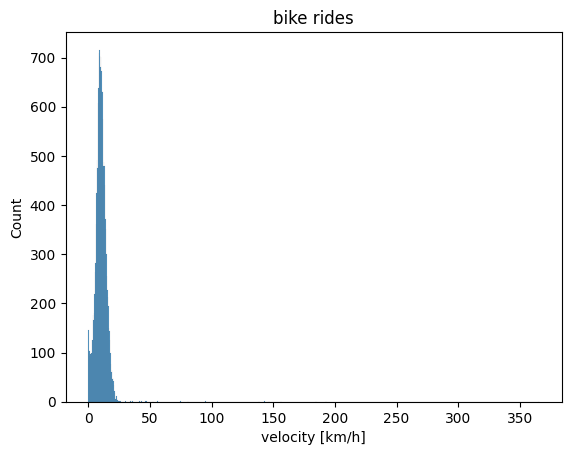

In [18]:
sns.histplot(data = df_rides['velocity_kmh']).set(xlabel = 'velocity [km/h]', title = 'bike rides')
plt.savefig('plots/rides_speed_no_cut.pdf')

### cut

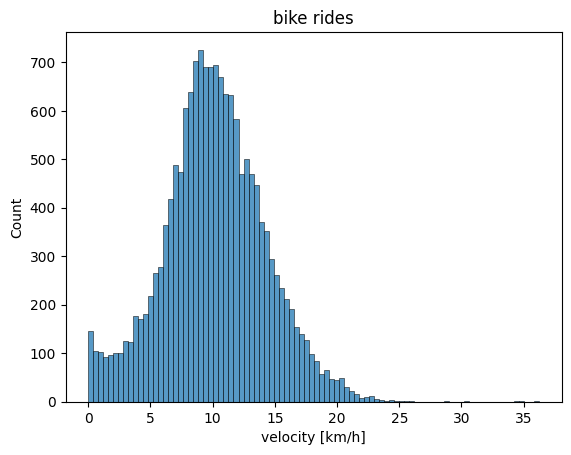

In [19]:
upper_cut_off_speed = df_rides['velocity_kmh'].mean() + 5*df_rides['velocity_kmh'].std()

series_duration_cut = df_rides['velocity_kmh']<upper_cut_off_speed

sns.histplot(data=df_rides[series_duration_cut]['velocity_kmh']).set(title = 'bike rides', xlabel = 'velocity [km/h]')

plt.savefig('plots/rides_speed.pdf')

In [20]:
df_rides[series_duration_cut]['velocity_kmh'].max()

np.float64(36.236929823379455)

In [21]:
df_fast = df_rides[~series_duration_cut]
df_rides = df_rides[series_duration_cut]
print(f'\nReduziert um {df_fast.shape[0]} von {df_rides.shape[0]+df_fast.shape[0]} to {df_rides.shape[0]}')


Reduziert um 19 von 16104 to 16085


## geographic distribution

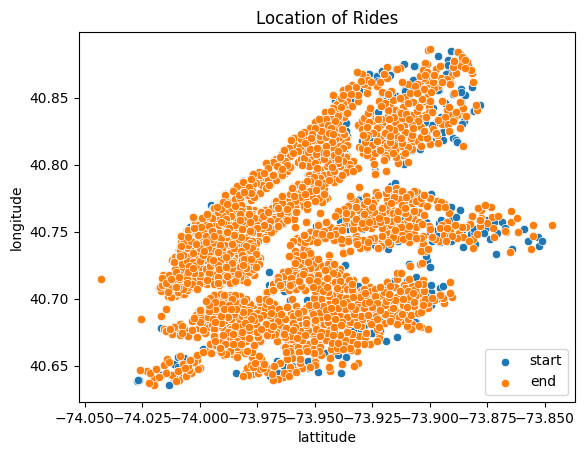

In [22]:
sns.scatterplot(y='start_lat', x='start_lng', data = df_rides)
sns.scatterplot(y='end_lat', x='end_lng', data = df_rides)
sns.scatterplot().set(xlabel = 'lattitude', ylabel = 'longitude')
plt.legend(loc='lower right', labels = ['start', 'end'])
plt.title('Location of Rides')

plt.savefig('plots/rides_location.pdf')

In [23]:
hull = ConvexHull(np.vstack([df_rides[['start_lng', 'start_lat']], df_rides[['end_lng', 'end_lat']]]))
bounds = np.vstack([df_rides[['start_lng', 'start_lat']], df_rides[['end_lng', 'end_lat']]])[hull.vertices]
border = Path(bounds)

## summary plots

In [24]:
df_rides.columns

Index(['rideable_type', 'started_at', 'ended_at', 'start_lat', 'start_lng',
       'end_lat', 'end_lng', 'member_casual', 'distance', 'duration_minutes',
       'velocity_kmh'],
      dtype='object')

[Text(0.5, 1.0, 'bike rides'), Text(0.5, 0, 'distance [km]')]

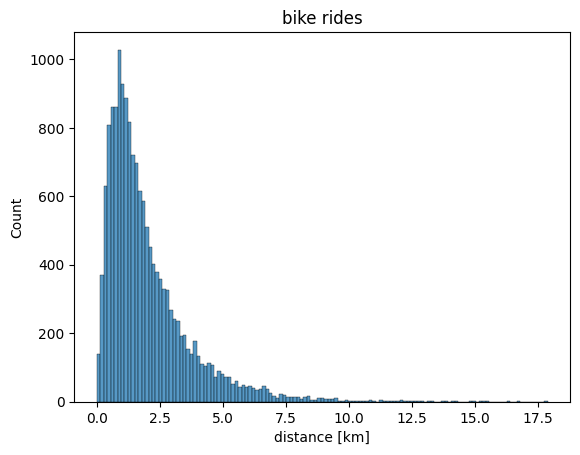

In [25]:
sns.histplot(data=df_rides['distance']).set(title = 'bike rides', xlabel = 'distance [km]')

[Text(0.5, 1.0, 'bike rides'), Text(0.5, 0, 'duration [min]')]

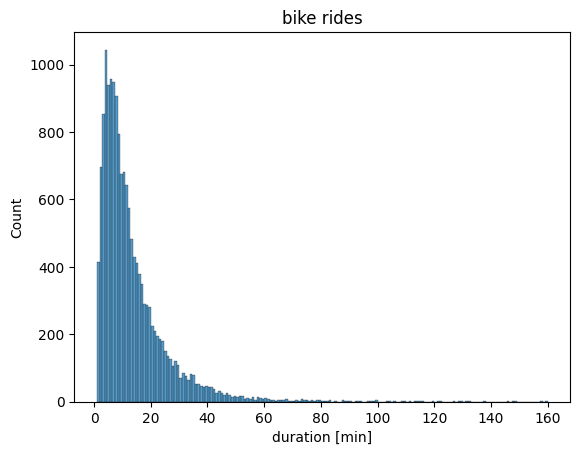

In [26]:
sns.histplot(data=df_rides['duration_minutes']).set(title = 'bike rides', xlabel = 'duration [min]')

[Text(0.5, 1.0, 'bike rides'), Text(0.5, 0, 'velocity [km/h]')]

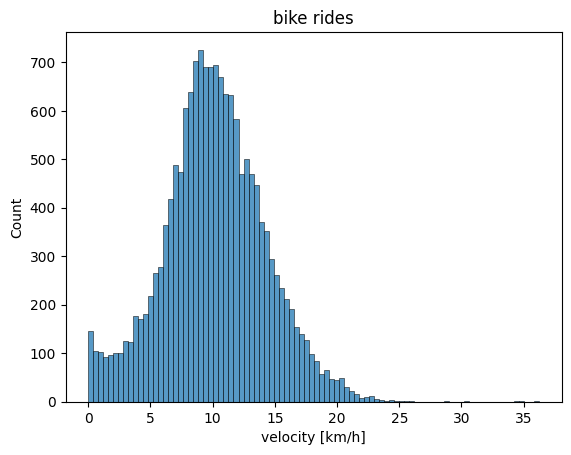

In [27]:
sns.histplot(data=df_rides['velocity_kmh']).set(title = 'bike rides', xlabel = 'velocity [km/h]')

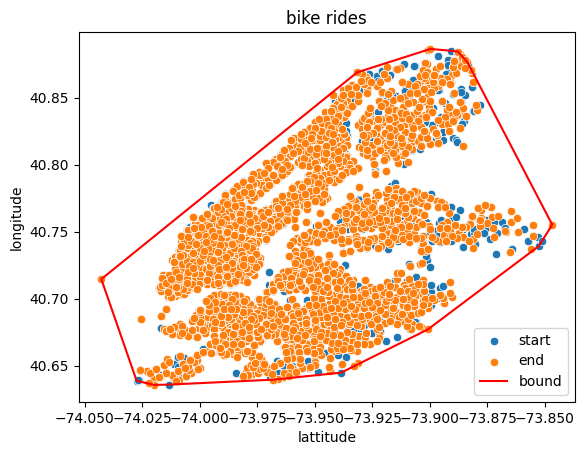

In [28]:
sns.scatterplot(y='start_lat', x='start_lng', data = df_rides)
sns.scatterplot(y='end_lat', x='end_lng', data = df_rides)
sns.scatterplot().set(xlabel = 'lattitude', ylabel = 'longitude')
plt.plot(np.append(bounds[:,0], bounds[0,0]), np.append(bounds[:, 1], bounds[0,1]), color='r')
plt.legend(loc='lower right', labels = ['start', 'end', 'bound'])
plt.title('bike rides')

plt.savefig('plots/rides_location_with_bound.pdf')

[Text(0, 0.5, 'lattitude'), Text(0.5, 0, 'longitude')]

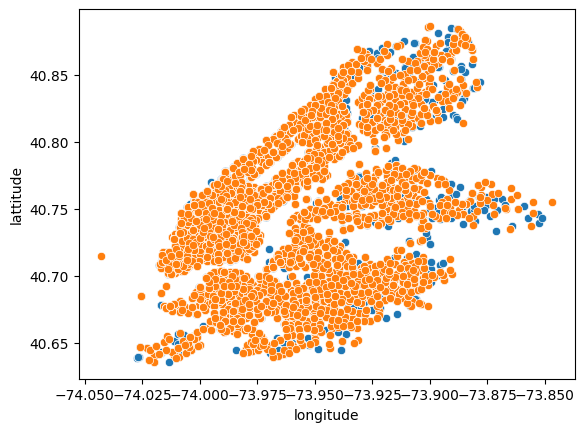

In [29]:
sns.scatterplot(y='start_lat', x='start_lng', data = df_rides)
sns.scatterplot(y='end_lat', x='end_lng', data = df_rides)
sns.scatterplot().set(ylabel = 'lattitude', xlabel = 'longitude')

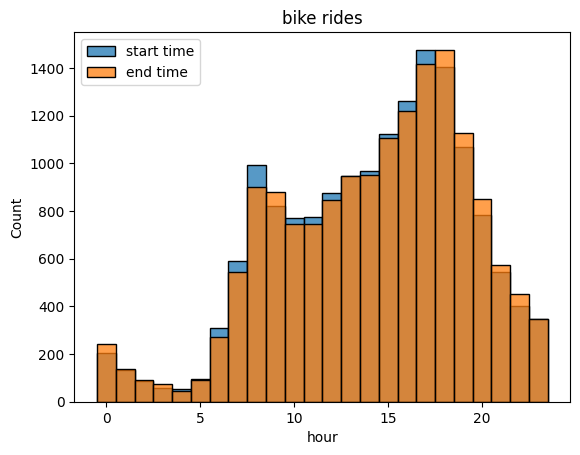

In [30]:
sns.histplot(df_rides['started_at'].dt.hour, discrete = True)#, label = 'start time')
sns.histplot(df_rides['ended_at'].dt.hour, discrete = True).set(xlabel = 'hour', title = 'bike rides')#, label = 'end time')
plt.legend(labels = ['start time', 'end time'])

plt.savefig('plots/rides_hour.pdf')

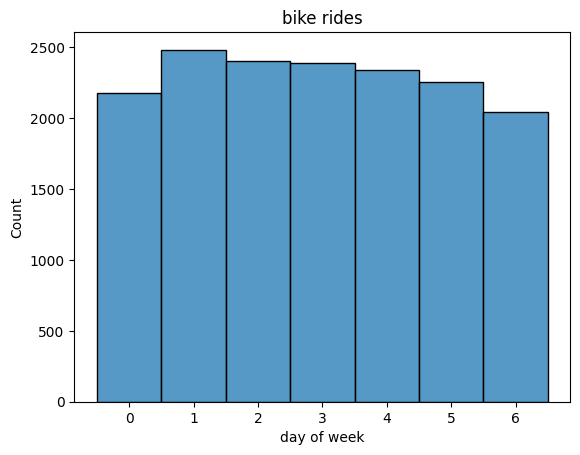

In [31]:
sns.histplot(df_rides['started_at'].dt.day_of_week, discrete = True).set(xlabel = 'day of week', title = 'bike rides')

plt.savefig('plots/rides_day_of_week.pdf')

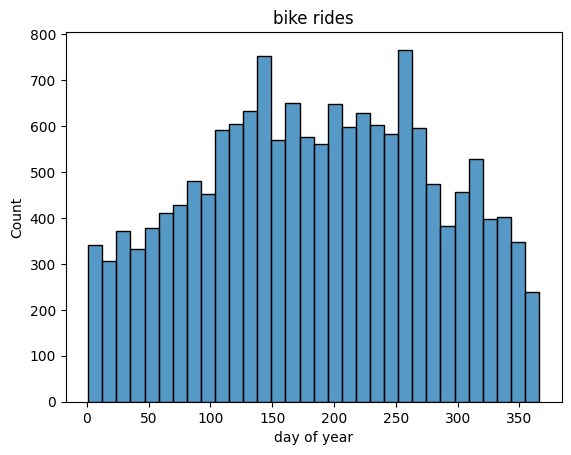

In [32]:
sns.histplot(df_rides['started_at'].dt.day_of_year).set(xlabel = 'day of year', title = 'bike rides')

plt.savefig('plots/rides_day_of_year.pdf')

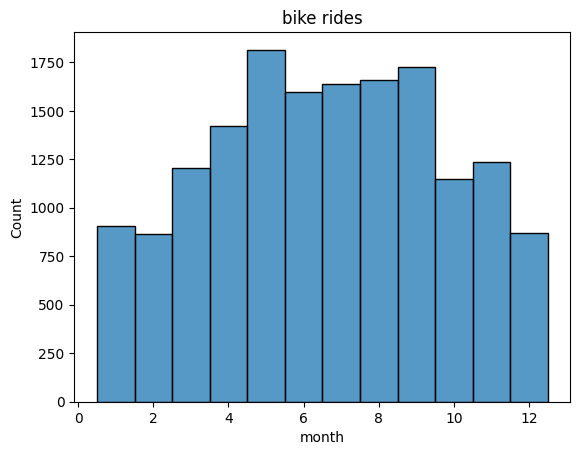

In [33]:
sns.histplot(df_rides['started_at'].dt.month, discrete = True).set(xlabel = 'month', title = 'bike rides')

plt.savefig('plots/rides_day_of_month.pdf')

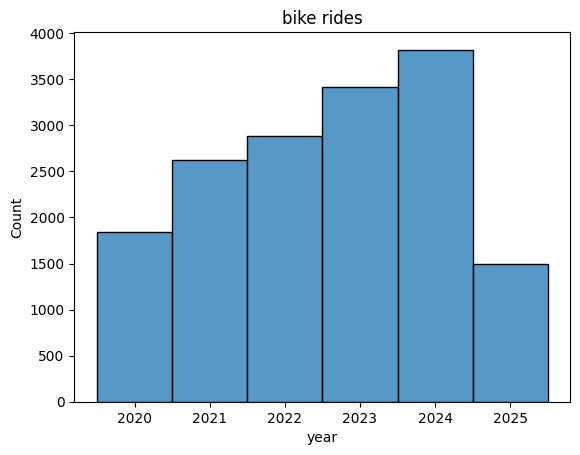

In [34]:
sns.histplot(df_rides['ended_at'].dt.year, discrete = True).set(xlabel = 'year', title = 'bike rides')

plt.savefig('plots/rides_year.pdf')

# Clean bike accident data

In [35]:
bike_accident = ((df_all_accidents['NUMBER OF CYCLIST INJURED'] > 0) | (df_all_accidents['NUMBER OF CYCLIST KILLED'] > 0)).astype(int)

df_all_accidents = pd.DataFrame({'date_time': pd.to_datetime(df_all_accidents['CRASH DATE'] + ' ' + df_all_accidents['CRASH TIME']),\
                       'lat': df_all_accidents['LATITUDE'], 'lng': df_all_accidents['LONGITUDE'], 'bike_accident': bike_accident})

In [ ]:
df_all_accidents['in_area'] = df_all_accidents.apply(lambda x: border.contains_point((x['lng'], x['lat'])), axis = 1).astype(int)

In [ ]:
df_bike_accidents = df_all_accidents[df_all_accidents['bike_accident'] == 1].drop('bike_accident', axis=1)

In [ ]:
df_total_bike_accidents = df_bike_accidents
df_bike_accidents = df_bike_accidents[(df_bike_accidents['in_area']==1) & \
(df_bike_accidents['date_time'] >= df_rides['started_at'].min()) &
(df_bike_accidents['date_time'] <= df_rides['started_at'].max()) ]
df_bike_accidents = df_bike_accidents.drop(columns = 'in_area', axis=1)

In [ ]:
df_bike_accidents.isna().sum()

## hour

### no cut

In [ ]:
sns.histplot(data=df_bike_accidents['date_time'].dt.hour, discrete = True).set(xlabel = 'hour of day', title = 'Bike Accidents')

plt.savefig('plots/bike_accidents_hour_unresampled.pdf')

In [ ]:
mask = df_bike_accidents['date_time'].dt.minute != 0
sns.histplot(data=df_bike_accidents[mask]['date_time'].dt.hour, discrete = True)\
.set(xlabel = 'hour', title = 'bike accidents not exactly on the hour')

plt.savefig('plots/bike_accidents_hour_not_on_hour.pdf')

In [ ]:
mask = df_bike_accidents['date_time'].dt.minute == 0
sns.histplot(data=df_bike_accidents[mask]['date_time'].dt.hour, discrete = True)\
.set(xlabel = 'hour', title = 'bike accidents exactly on the hour')

plt.savefig('plots/bike_accidents_hour_on_hour_unresampled.pdf')

### cut

In [ ]:
mask = df_bike_accidents['date_time'].dt.minute != 0
not_on_hour = df_bike_accidents[mask]['date_time'].dt.hour.value_counts()
on_hour = df_bike_accidents[~mask]['date_time'].dt.hour.value_counts()

In [ ]:
actual = on_hour[0]
prob_of_0 = not_on_hour[0] / not_on_hour.sum()
expect = prob_of_0 * on_hour.sum() 

In [ ]:
temp = pd.DataFrame.copy(on_hour)
temp[0] = 0
expect_res = (actual - expect) * temp / temp.sum()
expect_res[0] = expect
p_dist = expect_res / expect_res.sum()

In [ ]:
random_state = 1
temp_df = df_bike_accidents['date_time']\
.apply(lambda x: x.replace(hour=np.random.choice(p_dist.index, p = p_dist)) if x.hour == 0 and x.minute == 0 else x)

In [ ]:
df_bike_accidents['date_time'] = temp_df

In [ ]:
sns.histplot(data=df_bike_accidents['date_time'].dt.hour, discrete = True).set(title = 'bike accidents', xlabel = 'hour')

plt.savefig('plots/bike_accidents_hour_resampled.pdf')

In [ ]:
mask = temp_df.dt.minute == 0
sns.histplot(data=temp_df[mask].dt.hour, discrete = True).set(title = 'bike accidents exactly on hour', xlabel = 'hour')

plt.savefig('plots/bike_accidents_hour_not_on_hour_resampled.pdf')

In [ ]:
mask = temp_df.dt.minute != 0
sns.histplot(data=temp_df[mask].dt.hour, discrete = True).set(xlabel = 'hour', title = 'bike accidents not exactly on hour')

## day of week

In [ ]:
sns.histplot(data = df_bike_accidents['date_time'].dt.day_of_week, discrete = True).set(xlabel = 'day of week', title='Bike Accidents')

plt.savefig('plots/bike_accidents_day_of_week.pdf')

## day of year

In [ ]:
sns.histplot(data = df_bike_accidents['date_time'].dt.day_of_year).set(xlabel = 'day of year', title='Bike Accidents')

plt.savefig('plots/bike_accidents_day_of_year.pdf')

## month

In [ ]:
sns.histplot(data = df_bike_accidents['date_time'].dt.month, discrete = True).set(xlabel = 'month', title='Bike Accidents')

plt.savefig('plots/bike_accidents_month.pdf')

## year

In [ ]:
sns.histplot(data = df_bike_accidents['date_time'].dt.year, discrete = True).set(xlabel = 'month', title='Bike Accidents')

plt.savefig('plots/bike_accidents_year.pdf')

# Clean not bike accident data

In [ ]:
df_not_bike_accidents = df_all_accidents[df_all_accidents['bike_accident'] != 1].drop('bike_accident', axis=1)

In [ ]:
df_not_bike_accidents = df_not_bike_accidents[(df_not_bike_accidents['in_area']==1) & \
(df_not_bike_accidents['date_time'] >= df_rides['started_at'].min()) &\
(df_not_bike_accidents['date_time'] <= df_rides['started_at'].max())]
df_not_bike_accidents = df_not_bike_accidents.drop(columns = 'in_area', axis=1)

In [ ]:
df_temp = df_not_bike_accidents.dropna()

#mask = df_temp['lat']>40

sns.scatterplot(x='lng', y='lat', data=df_temp)
sns.scatterplot(x='start_lng', y='start_lat', data=df_rides)

In [ ]:
df_not_bike_accidents.isna().sum()

In [ ]:
df_not_bike_accidents=df_not_bike_accidents.dropna()

### no cut

In [ ]:
sns.histplot(data=df_not_bike_accidents['date_time'].dt.hour, discrete = True).set(xlabel = 'hour of day', title = 'Not Bike Accidents')

plt.savefig('plots/not_bike_accidents_hour_unresampled.pdf')

In [ ]:
mask = df_not_bike_accidents['date_time'].dt.minute != 0
sns.histplot(data=df_not_bike_accidents[mask]['date_time'].dt.hour, discrete = True)\
.set(xlabel = 'hour', title = 'not bike accidents not exactly on the hour')

plt.savefig('plots/not_bike_accidents_hour_not_on_hour.pdf')

In [ ]:
mask = df_not_bike_accidents['date_time'].dt.minute == 0
sns.histplot(data=df_not_bike_accidents[mask]['date_time'].dt.hour, discrete = True)\
.set(xlabel = 'hour', title = 'not bike accidents exactly on the hour')

plt.savefig('plots/not_bike_accidents_hour_on_hour_unresampled.pdf')

### cut

In [ ]:
mask = df_not_bike_accidents['date_time'].dt.minute != 0
not_on_hour = df_not_bike_accidents[mask]['date_time'].dt.hour.value_counts()
on_hour = df_not_bike_accidents[~mask]['date_time'].dt.hour.value_counts()

In [ ]:
actual = on_hour[0]
prob_of_0 = not_on_hour[0] / not_on_hour.sum()
expect = prob_of_0 * on_hour.sum() 

In [ ]:
temp = pd.DataFrame.copy(on_hour)
temp[0] = 0
expect_res = (actual - expect) * temp / temp.sum()
expect_res[0] = expect
p_dist = expect_res / expect_res.sum()

In [ ]:
random_state = 1
temp_df = df_not_bike_accidents['date_time']\
.apply(lambda x: x.replace(hour=np.random.choice(p_dist.index, p = p_dist)) if x.hour == 0 and x.minute == 0 else x)

In [ ]:
df_not_bike_accidents['date_time'] = temp_df

In [ ]:
sns.histplot(data=df_not_bike_accidents['date_time'].dt.hour, discrete = True).set(title = 'not bike accidents', xlabel = 'hour')

plt.savefig('plots/not_bike_accidents_hour_resampled.pdf')

In [ ]:
mask = temp_df.dt.minute == 0
sns.histplot(data=df_not_bike_accidents['date_time'][mask].dt.hour, discrete = True)\
.set(title = 'not bike accidents exactly on hour', xlabel = 'hour')

plt.savefig('plots/not_bike_accidents_hour_not_on_hour_resampled.pdf')

In [ ]:
mask = temp_df.dt.minute != 0
sns.histplot(data=df_not_bike_accidents['date_time'].dt.hour, discrete = True)\
.set(xlabel = 'hour', title = 'not bike accidents not exactly on hour')

## day of week

In [ ]:
sns.histplot(data = df_not_bike_accidents['date_time'].dt.day_of_week, discrete = True)\
.set(xlabel = 'day of week', title='Not Bike Accidents')

plt.savefig('plots/not_bike_accidents_day_of_week.pdf')

## day of year

In [ ]:
sns.histplot(data = df_not_bike_accidents['date_time'].dt.day_of_year, binwidth=15)\
.set(xlabel = 'day of year', title='Not Bike Accidents')

plt.savefig('plots/not_bike_accidents_day_of_year.pdf')

## month

In [ ]:
sns.histplot(data = df_not_bike_accidents['date_time'].dt.month, discrete = True)\
.set(xlabel = 'month', title='Not Bike Accidents')

plt.savefig('plots/not_bike_accidents_month.pdf')

## year

In [ ]:
sns.histplot(data = df_not_bike_accidents['date_time'].dt.year, discrete = True)\
.set(xlabel = 'month', title='Not Bike Accidents')

plt.savefig('plots/not_bike_accidents_year.pdf')

# Heat maps

In [ ]:
hist_bike_accidents, x_edge_accidents, y_edge_accidents = np.histogram2d(x=df_bike_accidents['lng'], y=df_bike_accidents['lat'], bins=100)
plt.imshow(hist_bike_accidents.T, interpolation='nearest', origin='lower', \
           extent=[x_edge_accidents[0], x_edge_accidents[-1], y_edge_accidents[0], y_edge_accidents[-1]])
plt.title('Bike Accidents Heat Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.savefig('plots/bike_accidents_heat_map.pdf')

In [ ]:
hist_rides, x_edge_rides, y_edge_rides = np.histogram2d(x=df_rides['start_lng'], y=df_rides['start_lat'], bins=100)
plt.imshow(hist_rides.T, interpolation='nearest', origin='lower', \
           extent=[x_edge_rides[0], x_edge_rides[-1], y_edge_rides[0], y_edge_rides[-1]])
plt.title('Rides Heat Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.savefig('plots/rides_heat_map.pdf')

# Export data frames

In [ ]:
"""
df_rides.to_pickle('data_frames/df_rides.pkl')
df_bike_accidents.to_pickle('data_frames/df_bike_accidents.pkl')
df_not_bike_accidents.to_pickle('data_frames/df_not_bike_accidents.pkl')
"""